# Characters

NEW REPLACEMENT

This data frame lists all characters, their movie, their gender, and their credit position. The `character_ID` column is later referenced in other data frames.

In [1]:
# import packages
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Loading in the data and basic summary

In [3]:
# creating the df
characters_df = pd.read_csv('./data/movie_characters_metadata.txt', sep='\s+\+\+\+\$\+\+\+\s?',
                            names = ['character_ID', 'character_name', 'movie_ID', 'movie_title', 'gender', 'credit_position'], 
                            dtype='string', engine='python', encoding='ISO-8859-1')

The data was all separated with ' +++$+++ ' and did not have column names. The README described what each column was in the data so I used that to create column names. Where logical, I made the index of the df the initial ID column.

In [4]:
characters_df.shape

(9035, 6)

In [5]:
characters_df.info()
# some characters are unnamed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9035 entries, 0 to 9034
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   character_ID     9035 non-null   string
 1   character_name   9033 non-null   string
 2   movie_ID         9035 non-null   string
 3   movie_title      9035 non-null   string
 4   gender           9035 non-null   string
 5   credit_position  9035 non-null   string
dtypes: string(6)
memory usage: 423.6 KB


In [6]:
characters_df.head()

,character_ID,character_name,movie_ID,movie_title,gender,credit_position
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6


In [7]:
characters_df.tail()

,character_ID,character_name,movie_ID,movie_title,gender,credit_position
9030,u9030,DURNFORD,m616,zulu dawn,?,?
9031,u9031,MELVILL,m616,zulu dawn,?,?
9032,u9032,NORRIS-NEWMAN,m616,zulu dawn,?,?
9033,u9033,STUART SMITH,m616,zulu dawn,?,?
9034,u9034,VEREKER,m616,zulu dawn,?,?


Some gender makers are missing for characters in this dataframe, I will work on filling in the missing data.

In [8]:
# how many characters are missing gender?
characters_df.groupby('gender').count()

,character_ID,character_name,movie_ID,movie_title,credit_position
gender,,,,,
?,6020,6018,6020,6020,6020
F,45,45,45,45,45
M,150,150,150,150,150
f,921,921,921,921,921
m,1899,1899,1899,1899,1899


Looks like a lot of missing gender markers! Looks like some of the flags are inconsist too, there is 'm' and 'M.'

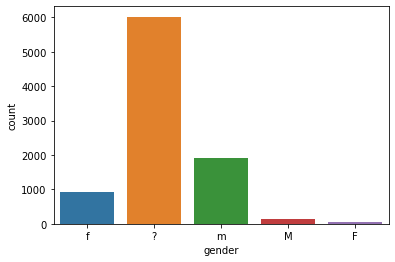

In [9]:
sns.countplot(x = "gender",
             data = characters_df)
plt.show()

More characters are missing gender markers than have gender markers.

In [10]:
# making all gender markers uppercase
characters_df['gender'] = characters_df.gender.map(lambda x: re.sub(r'f', r'F', x))
characters_df['gender'] = characters_df.gender.map(lambda x: re.sub(r'm', r'M', x))

In [11]:
characters_df.describe()

,character_ID,character_name,movie_ID,movie_title,gender,credit_position
count,9035,9033,9035,9035,9035,9035
unique,9035,5355,617,617,3,57
top,u0,MAN,m289,casino,?,?
freq,1,44,44,44,6020,6356


In [12]:
# adding separate columns for first and last name
# name = 'Mack Campbell'
# name.split()[0] # first name
# name.split()[1] # last name
# what if they have more than 2 words?

## Generating Gender Markers

In [13]:
# df for characters without gender markers
characters_ng_df = characters_df[characters_df.gender == '?']

In [14]:
# df for characters with gender markers, these will get remerged later
characters_g_df = characters_df[characters_df.gender != '?']

In [15]:
characters_ng_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6020 entries, 1 to 9034
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   character_ID     6020 non-null   string
 1   character_name   6018 non-null   string
 2   movie_ID         6020 non-null   string
 3   movie_title      6020 non-null   string
 4   gender           6020 non-null   object
 5   credit_position  6020 non-null   string
dtypes: object(1), string(5)
memory usage: 329.2+ KB


In [16]:
# there are two characters missing names
characters_ng_df[characters_ng_df.character_name.isnull()]

,character_ID,character_name,movie_ID,movie_title,gender,credit_position
3764,u3764,<NA>,m248,arctic blue,?,?
6558,u6558,<NA>,m436,memento,?,?


In [17]:
# i will replace them with empty strings for now
characters_ng_df['character_name'].fillna('', inplace=True)

<ipython-input-17-ee62cec4db58>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_ng_df['character_name'].fillna('', inplace=True)


I will use the NLTK names list and specific strings to help fill in missing gender markers.

### NLTK Names List

In [18]:
# I will use the names corpus from NLTK to fill in some gaps in gender data
names = nltk.corpus.names
male_names = names.words('male.txt')
female_names = names.words('female.txt')

In [19]:
male_names[:5]

['Aamir', 'Aaron', 'Abbey', 'Abbie', 'Abbot']

In [20]:
female_names[:5]

['Abagael', 'Abagail', 'Abbe', 'Abbey', 'Abbi']

Some names appear on both lists, this will be addressed below. I will add a gender marker 'A' for ambiguous, the names in both lists as well as certain strings will make up this category.

### Using Strings

Miss Perky is a character, turns out there are numerous other characters with honorifics and stereotypically gendered words (boy, girl, brother, sister, etc.). 

In [370]:
characters_ng_df[characters_ng_df.character_name.str.contains('')]

,character_ID,character_name,movie_ID,movie_title,gender,credit_position
4273,u4273,CAMERAMAN,m285,broadcast news,unknown,?
4936,u4936,CAMERAMAN BILL,m329,ed wood,unknown,?


### Using the Dictionaries

In [371]:
# code created by Na-Rae Han and refined by me
def getGender(name):
    nltkname_m = set([n.upper() for n in male_names])
    nltkname_f = set([n.upper() for n in female_names])
    nltkname_mf = nltkname_m.intersection(nltkname_f)
    name = name.upper()  # uppercase incoming name
    if name in nltkname_mf: return 'A'
    elif name in nltkname_f: return 'F'
    elif name in nltkname_m: return 'M'
    elif re.match(r'(.* ?)?(\bMAN\b|BOYFRIEND|DAD|FATHER|GRANDFATHER|GRANDDAD|GRANDPA|GRANDSON|BROTHER|BOY|SIR|MR.|MISTER|UNCLE|MALE|\bHERR\b|HOST\b|LORD|PRIEST|COUNT|WIZARD|EMPEROR|GOVERNOR|DUDE)', name):
        return 'M'
    elif 'WOMAN' in name or re.match(r'(.* ?)?(MS\.|MISS\b|GIRL|WIFE|MOM|MOTHER|DAUGHTER|SISTER|MRS.|AUNT|MAMA|\bMA|LADY|\bFEMALE|FRAU|PRINCESS|QUEEN|GRANDMA|GRANDMOTHER|WAITRESS|HOSTESS|NUN|WITCH|ACTRESS|GOVERNESS|STEWARDESS|CHICK)', name): 
        return 'F'
    elif re.match(r'(DR. |DR |DOCTOR|PROFESSOR|TEACHER|JUDGE|PILOT)', name): 
        return 'A'
    else:
        return 'unknown'

In [372]:
characters_ng_df['gender'] = characters_ng_df['character_name'].map(getGender)

<ipython-input-372-d2c06cdbc673>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_ng_df['gender'] = characters_ng_df['character_name'].map(getGender)


In [373]:
characters_ng_df.groupby('gender').count()

,character_ID,character_name,movie_ID,movie_title,credit_position
gender,,,,,
A,515,515,515,515,515
F,1076,1076,1076,1076,1076
M,1550,1550,1550,1550,1550
unknown,2879,2879,2879,2879,2879


Initially 6020 characters were missing gender markers. Using NLTK name list and strings I added 2,883 gender markers.
Just NLTK: 2229

NLTK + initial strings: 2883

second pass: 2894

third pass: 2907 

fourth pass: 2920

FIFTH PASS: 3062

sixth pass 3122

seventh pass: 3136

eighth pass: 3141

900+ added by strings!

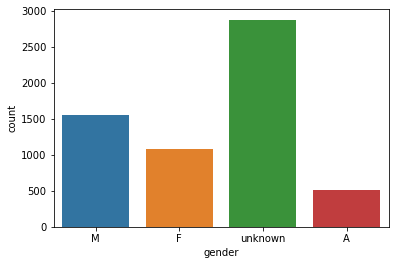

In [375]:
sns.countplot(x = "gender",
             data = characters_ng_df)
plt.show()
# still a lot of unknown genders, but about half were resolved

## Remerging the dataframes

In [377]:
# now that i have made progress on adding gender markers, lets add the two dataframes back together
characters_update_df = pd.concat([characters_ng_df, characters_g_df])

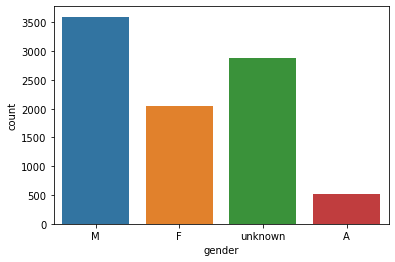

In [379]:
# updated dataframe gender breakdown
sns.countplot(x = "gender",
             data = characters_update_df)
plt.show()

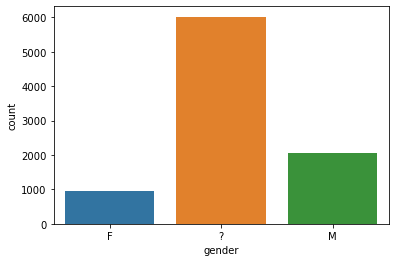

In [380]:
# compared to the original dataframe! huge improvement, I was able to cut the unknown gender markers down by half
sns.countplot(x = "gender",
             data = characters_df)
plt.show()

## Pickling the data and creating a csv

In [381]:
import pickle

In [382]:
# pickle the data to use in other notebooks for further analysis
f = open('characters_update_df.pkl', 'wb')
pickle.dump(characters_update_df, f, -1)
f.close()

In [32]:
characters_update_df.to_csv('./new_data/characters_df.csv', header=True)